In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Filtro de Kalman - Medicion Directa Voltimetro

### Creamos un estado inicial

Valores del estado

[$V (volt)$]

In [2]:
NUM_STATES = 1
INITIAL_VAL = 0.5
INITIAL_STD = 0.05

x = np.array([INITIAL_VAL], np.double)
x = np.reshape(x, [NUM_STATES,1])

# Desvios standard de cada variable (esperados)
# [V (volt)]
P_std = np.array([INITIAL_STD], np.double)
# Armamos la matriz de covarianza inicial
P = np.eye(NUM_STATES,NUM_STATES)*np.power(P_std,2)

print("Estado inicial:")
print(x)
print("Matriz covarianza inicial:")
print(P)

Estado inicial:
[[0.5]]
Matriz covarianza inicial:
[[0.0025]]


### Ploteo el estado inicial

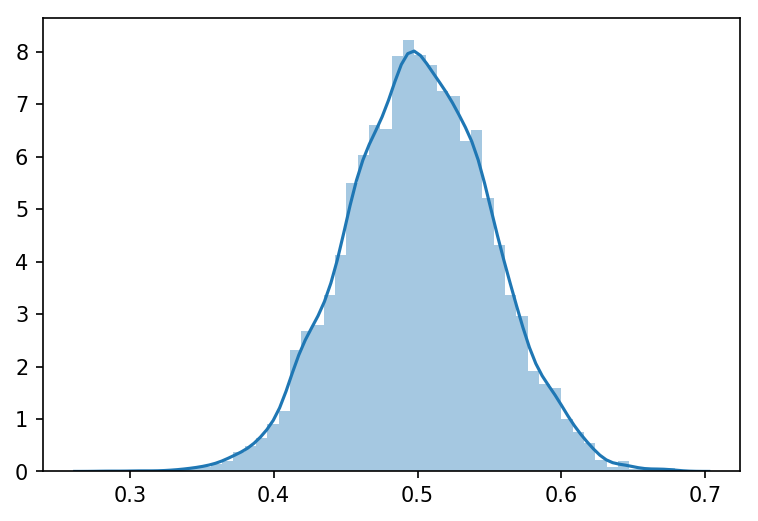

In [3]:
plot_samples=10000

fig = plt.figure(dpi=150)
sample_aux = np.random.multivariate_normal(x[0],P, size=plot_samples)
sns.distplot(sample_aux, kde=True, hist=True);
plt.show()

## Definimos las reglas del modelo 

Debemos describir como esperamos que evolucione el estado actual dado que paso un cierto tiempo y conociendo las reglas.
Este ejemplo es un voltimetro que mide un valor DC, lo esperado es que el valor no cambie...

In [4]:
# Definimos la operacion como:
# x(t) = x(t-1)
# En forma matricial
F = np.array([[1]])

# También podemos definir error esperado en el proceso,
# Este ruido puede representar algun efect ajeno a nuestro
# modelo que afecta al sistema o simplemente incertidumbre
# existente en el poder de predicción del modelo.
# En este caso podemos agregar aca un poco de desconfianza a
# que todo siga igual...
# Cuanto confiamos en el modelo, osea, que la DC es constante y no varia
MODEL_STD = 0.00000001 # Volt
Q = np.ones(P.shape)*(MODEL_STD**2)

# Calculamos un nuevo estado

### Estado estimado

Suponemos que medimos una aceleracion dada por:

In [5]:
x_estim = np.matmul(F,x)

### Calculamos la varianza del estado estimado

La nueva matriz de covarianza se obtiene propagando la nueva covarianza:

In [6]:
P_estim = np.matmul(np.matmul(F,P),F.T) + Q

###  Ploteamos el estado estimado

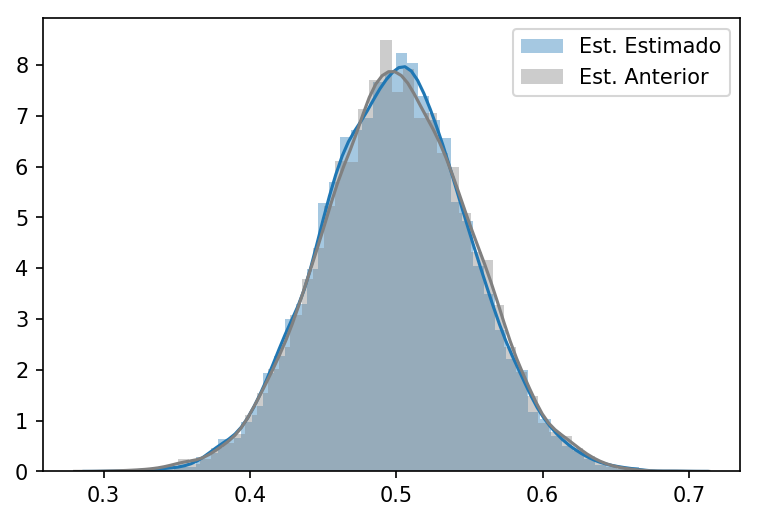

In [7]:
plot_samples=10000

fig = plt.figure(dpi=150)
sample_aux = np.random.multivariate_normal(x_estim[0],P_estim, size=plot_samples)
sns.distplot(sample_aux, kde=True, hist=True, label="Est. Estimado");
sample_aux = np.random.multivariate_normal(x[0],P, size=plot_samples)
sns.distplot(sample_aux, kde=True, hist=True, color='grey', label="Est. Anterior");
plt.legend();
plt.show()

## Medimos el nuevo estado

Aparte de estimar el proximo estado también vamos a tener una medición directa o indirecta de dicho estado. Podemos agregar esta información para mejorar nuestra medición.

Suponemos que medimos con un voltimetro muy malo, la medición es directa y con mucha incertidumbre
 
 $[V (volt)]$

In [8]:
ERROR_VOLT = 0.04
NUM_MEDICIONES = 1

z = np.array([0.4], np.double)
z = np.reshape(z, [NUM_MEDICIONES,1])

H = np.eye(NUM_MEDICIONES) # Corresponden exactamente a los estados internos
z_estim = np.matmul(H,x_estim)

R_std = np.array([ERROR_VOLT], np.double)
# Armamos la matriz de covarianza de las mediciones,
R = np.eye(NUM_MEDICIONES,NUM_MEDICIONES)*np.power(R_std,2)

### Ploteamos el estado medido

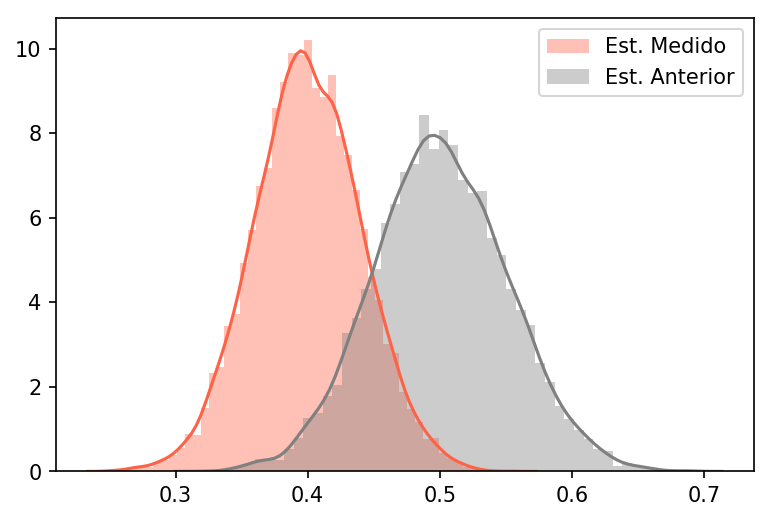

In [9]:
plot_samples=10000

fig = plt.figure(dpi=150)
sample_aux = np.random.multivariate_normal(z[0],R, size=plot_samples)
sns.distplot(sample_aux, kde=True, hist=True, color='tomato', label="Est. Medido");
sample_aux = np.random.multivariate_normal(x[0],P, size=plot_samples)
sns.distplot(sample_aux, kde=True, hist=True, color='grey', label="Est. Anterior");
plt.legend();
plt.show()

# Ahora debemos combinar ambos estados

La idea es sumar obtener la distribución que represente con mayor verosimilidad la tensión medida, combinando la medicion y el valor esperado

### Combinación grafica

Podemos saber a ojo cual va a ser el nuevo estado multiplicando las destribuciones entre si.
El resultado de esto no es gausseano pero nos orienta.

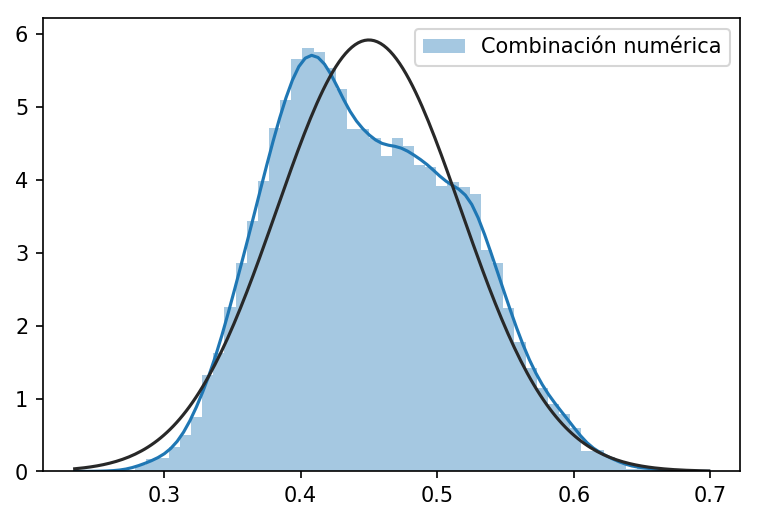

In [10]:
from scipy.stats import norm
plot_samples=10000

fig = plt.figure(dpi=150)
sample_aux_1 = np.random.multivariate_normal(z[0],R, size=plot_samples)
sample_aux_2 = np.random.multivariate_normal(x_estim[0],P_estim, size=plot_samples)
sample_conv = np.concatenate((sample_aux_1,sample_aux_2),axis=0)
sns.distplot(sample_conv, kde=True, hist=True, fit=norm, label="Combinación numérica");
plt.legend();
plt.show()

### Calculamos el nuevo estado matematicamente

Definimos y calculamos la ganancia de Kalman
$K = P_{estim} . H^T . ( H . P_{estim} . H^T  + R)^{-1}$


In [11]:
K = np.matmul( P_estim, np.matmul( H.T , np.linalg.inv( np.matmul(H,np.matmul(P_estim,H.T)) + R ) ) )

Calculamos el estado final usando la información estimada y medida:

In [12]:
x_new = x_estim+np.matmul(K, (z-np.matmul(H,x_estim)))
#P_new = np.matmul( np.identity(NUM_STATES) - np.matmul(Kg,H) , P_estim )
P_new = P_estim - np.matmul( K, np.matmul(H , P_estim ))

## Ploteamos y comparamos

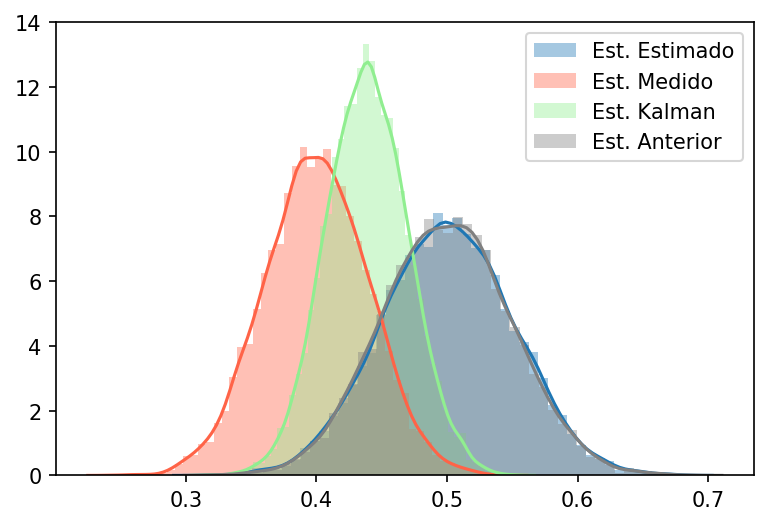

In [13]:
plot_samples=10000

fig = plt.figure(dpi=150)
sample_aux = np.random.multivariate_normal(x_estim[0],P_estim, size=plot_samples)
sns.distplot(sample_aux, kde=True, hist=True,label="Est. Estimado");
sample_aux = np.random.multivariate_normal(z[0],R, size=plot_samples)
sns.distplot(sample_aux, kde=True, hist=True, color='tomato', label="Est. Medido");
sample_aux = np.random.multivariate_normal(x_new[0],P_new, size=plot_samples)
sns.distplot(sample_aux, kde=True, hist=True, color='lightgreen', label="Est. Kalman");
sample_aux = np.random.multivariate_normal(x[0],P, size=plot_samples)
sns.distplot(sample_aux, kde=True, hist=True, color='grey', label="Est. Anterior");
plt.legend();
plt.show()

# Ahora en Loop

In [14]:
NUM_ITERACIONES = 1000

INITIAL_VAL = 0.2

# Cuanto confiamos en el estado inicial que tenemos
INITIAL_STD = 0.1 # Volt
# El error de nuestro voltimetro (suponemos independiente de la medicón por comodidad)
ERROR_VOLT = 0.04 # Volt
# Cuanto confiamos en el modelo, osea, que la DC es constante y no varia
MODEL_STD = 0.00000001 # Volt



# Media y covarianza de la medicion a simular (no la conocemos en realidad)
MED_COVAR = [[(0.000001)**2]]
MED_MEAN = [0.40389]



# Regeneramos los vectores iniciales
x = np.array([INITIAL_VAL], np.double)
x = np.reshape(x, [NUM_STATES,1])
P_std = np.array([INITIAL_STD], np.double)
P = np.eye(NUM_STATES,NUM_STATES)*np.power(P_std,2)

Q = np.ones(P.shape)*(MODEL_STD**2)

# Reservamos memoria para la evolucion del estado
x_hist = np.zeros((NUM_ITERACIONES,NUM_STATES,1))
P_hist = np.zeros((NUM_ITERACIONES,NUM_STATES,NUM_STATES))


for idx_iter in range(NUM_ITERACIONES):
    
    # Hacemos una estimacion
    x_estim = np.matmul(F,x)
    P_estim = np.matmul(np.matmul(F,P),F.T) + Q
    
    # Hacemos una medicion
    z = np.random.multivariate_normal(MED_MEAN,MED_COVAR) + np.random.multivariate_normal([0],[[ERROR_VOLT]])
    z = np.reshape(z, [NUM_MEDICIONES,1])

    R_std = np.array([ERROR_VOLT], np.double)
    # Armamos la matriz de covarianza de las mediciones,
    R = np.eye(NUM_MEDICIONES,NUM_MEDICIONES)*np.power(R_std,2)
    
    # Calculamos la ganancia de Kalman
    K = np.matmul( P_estim, np.matmul( H.T , np.linalg.inv( np.matmul(H,np.matmul(P_estim,H.T)) + R ) ) )
    
    # Actualizamos al nuevo estado
    x = x_estim + np.matmul( K, (z-np.matmul(H,x_estim)))
    P = P_estim - np.matmul( K,    np.matmul(H,P_estim) )
    
    # Guardamos el estado actual para ver la evolucion
    x_hist[idx_iter,:] = x
    P_hist[idx_iter,:] = P
    
    
print("Estado final:")
print(x)
print("Desvio estandar final:")
print(np.sqrt(P))
    
    

Estado final:
[[0.39373198]]
Desvio estandar final:
[[0.00126481]]


## Ploteamos la evolución

/home/rawthil/Documents/VE-Medidas/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


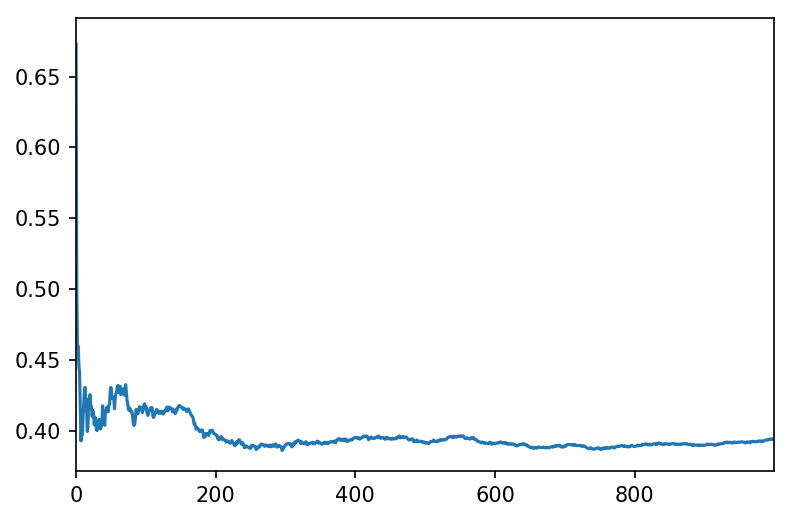

In [15]:
plot_samples=100

fig = plt.figure(dpi=150)
P_hist_aux = np.multiply(np.eye(NUM_ITERACIONES,NUM_ITERACIONES),P_hist[:,0,0])

sample_aux = np.random.multivariate_normal(np.squeeze(x_hist[:,0]),P_hist_aux, size=plot_samples)
sns.tsplot(sample_aux);

plt.show()



/home/rawthil/Documents/VE-Medidas/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


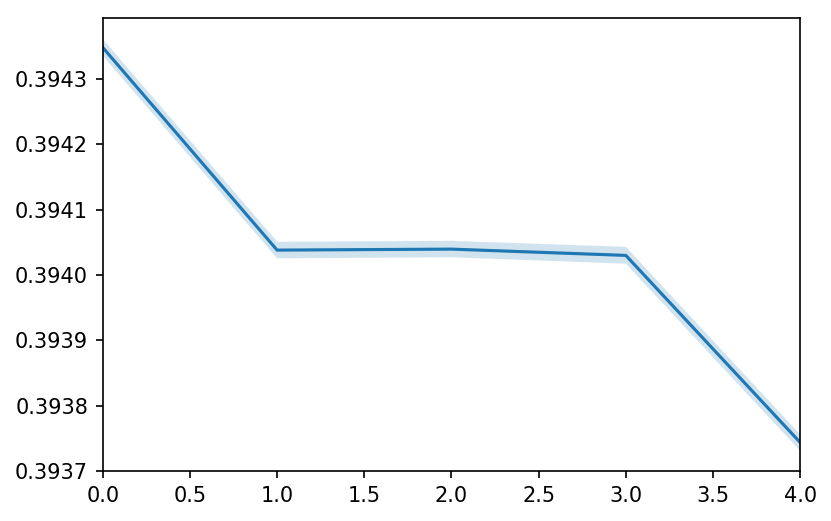

In [16]:
plot_samples=10000
NUM_ITERACIONES_AUX = 5

fig = plt.figure(dpi=150)
P_hist_aux = np.multiply(np.eye(NUM_ITERACIONES_AUX,NUM_ITERACIONES_AUX),P_hist[-NUM_ITERACIONES_AUX:,0,0])

sample_aux = np.random.multivariate_normal(np.squeeze(x_hist[-NUM_ITERACIONES_AUX:,0]),P_hist_aux, size=plot_samples)
sns.tsplot(sample_aux);

plt.show()
